# OpenML CC18 Metalearning Benchmark

In [1]:
%matplotlib inline

In [253]:
import re
import tarfile

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandera as pa
import plotly.express as px
import seaborn as sns
import yaml
from IPython.display import display, Markdown

from pathlib import Path

In [8]:
# environment variables

JOB = 376
RESULTS_ROOT = Path("..") / "floyd_outputs"
OUTPUT_PATH = RESULTS_ROOT / str(JOB) / "output.tar"

#### Experiment Config

In [9]:
with tarfile.open(OUTPUT_PATH) as tar:
    file = tar.extractfile(tar.getmember("./experiment_config.yml"))
    experiment_config = yaml.safe_load(file)
    
print(json.dumps(experiment_config, indent=4))

{
    "name": "metalearn_a2c_binary",
    "experiment_type": "METALEARN_REINFORCE",
    "description": "metalearning with A2C architecture",
    "created_at": "2020-01-20-16-56-31",
    "git_hash": "633ce78",
    "parameters": {
        "datasets": null,
        "test_datasets": null,
        "output_fp": "/output",
        "input_size": 60,
        "hidden_size": 60,
        "output_size": 60,
        "n_layers": 3,
        "dropout_rate": 0.2,
        "entropy_coef": 0.1,
        "entropy_coef_anneal_to": 0.0,
        "entropy_coef_anneal_by": null,
        "normalize_reward": false,
        "gamma": 0.99,
        "meta_reward_multiplier": 1.0,
        "n_episodes": 1000,
        "n_iter": 50,
        "n_eval_iter": 50,
        "learning_rate": 0.005,
        "optim_beta1": 0.9,
        "optim_beta2": 0.999,
        "env_sources": [
            "SKLEARN",
            "OPEN_ML",
            "AUTOSKLEARN_BENCHMARK"
        ],
        "test_env_sources": [
            "OPEN_ML_BENCHMARK

## Training

In [10]:
with tarfile.open(OUTPUT_PATH) as tar:
    training_result_files = [
        m for m in tar.getmembers()
        if m.name.startswith("./metalearn_training_results_trial_")
    ]
    training_results = (
        pd.concat([
            pd.read_csv(tar.extractfile(member))
            for member in training_result_files
        ])
        .sort_values(["trial_num", "episode"])
    )

training_results.head(3)

,episode,data_env_names,target_type,scorers,total_losses,actor_losses,critic_losses,entropy_losses,gradient_norms,mean_rewards,...,std_validation_scores,best_validation_scores,n_successful_mlfs,n_unique_mlfs,n_unique_hyperparams,mlf_diversity,hyperparam_diversity,entropy_coefficient,trial_num,learning_rate
0,1,openml.kddcup09_churn,BINARY,roc_auc,275.085724,-25.613035,300.816101,-0.117352,1.0,-1.000000,...,NaN,NaN,0,0,0,NaN,NaN,0.1,0,0.0
1,2,openml.ailerons,BINARY,roc_auc,4.273395,1.499914,2.890592,-0.117111,1.0,-0.088209,...,0.148953,0.944876,27,27,27,1.0,1.0,0.1,0,0.0
2,3,openml.fried,BINARY,roc_auc,9.390445,-6.236135,15.744648,-0.118069,1.0,-0.133157,...,0.181052,0.979511,24,24,24,1.0,1.0,0.1,0,0.0


### Mean Rewards per Episode

It looks like the experiment output is missing training results
data for trials 1, 2, 3, and 6. Not sure why this happened, need
to check that the trail numbers are properly recorded in the
`metalearn.experiment` module.

In [11]:
training_results.query("episode == 1")

,episode,data_env_names,target_type,scorers,total_losses,actor_losses,critic_losses,entropy_losses,gradient_norms,mean_rewards,...,std_validation_scores,best_validation_scores,n_successful_mlfs,n_unique_mlfs,n_unique_hyperparams,mlf_diversity,hyperparam_diversity,entropy_coefficient,trial_num,learning_rate
0,1,openml.kddcup09_churn,BINARY,roc_auc,275.085724,-25.613035,300.816101,-0.117352,1.0,-1.0,...,NaN,NaN,0,0,0,NaN,NaN,0.1,0,0.0000
0,1,openml.kddcup09_churn,BINARY,roc_auc,275.367340,-25.987476,301.472076,-0.117254,1.0,-1.0,...,NaN,NaN,0,0,0,NaN,NaN,0.1,1,0.0005
0,1,openml.kddcup09_churn,BINARY,roc_auc,276.687469,-26.032255,302.835388,-0.115652,1.0,-1.0,...,NaN,NaN,0,0,0,NaN,NaN,0.1,2,0.0050
0,1,openml.kddcup09_churn,BINARY,roc_auc,275.846558,-25.195295,301.161987,-0.120148,1.0,-1.0,...,NaN,NaN,0,0,0,NaN,NaN,0.1,3,0.0500


In [12]:
training_results.trial_num.unique()

array([0, 1, 2, 3])

In [140]:
HYPERPARAMETERS = ["learning_rate"]

trial_num_map = (
    training_results[["trial_num"] + HYPERPARAMETERS].drop_duplicates()
    .set_index("trial_num")
    .to_dict(orient="index")
)
trial_num_map

{0: {'learning_rate': 0.0},
 1: {'learning_rate': 0.0005},
 2: {'learning_rate': 0.005},
 3: {'learning_rate': 0.05}}

Roughly define regret as ${validation\ score}_{max} - {validation\ score}_{mean}$
for a particular episode. Where ${validation\ score}_{max}$ is the best validation
set found by all of the hyperparameter conditions for a particular dataset.

In [15]:
optimal_validation_scores = training_results.groupby("data_env_names").best_validation_scores.max()

training_results.assign(optimal_validation_scores=lambda df: df.data_env_names.map(optimal_validation_scores))

,episode,data_env_names,target_type,scorers,total_losses,actor_losses,critic_losses,entropy_losses,gradient_norms,mean_rewards,...,best_validation_scores,n_successful_mlfs,n_unique_mlfs,n_unique_hyperparams,mlf_diversity,hyperparam_diversity,entropy_coefficient,trial_num,learning_rate,optimal_validation_scores
0,1,openml.kddcup09_churn,BINARY,roc_auc,275.085724,-25.613035,300.816101,-1.173517e-01,1.0,-1.000000,...,NaN,0,0,0,NaN,NaN,0.1,0,0.00,NaN
1,2,openml.ailerons,BINARY,roc_auc,4.273395,1.499914,2.890592,-1.171114e-01,1.0,-0.088209,...,0.944876,27,27,27,1.000000,1.0,0.1,0,0.00,0.960119
2,3,openml.fried,BINARY,roc_auc,9.390445,-6.236135,15.744648,-1.180689e-01,1.0,-0.133157,...,0.979511,24,24,24,1.000000,1.0,0.1,0,0.00,0.982172
3,4,openml.pol,BINARY,roc_auc,16.040136,-6.774127,22.931843,-1.175780e-01,1.0,-0.326058,...,0.994085,18,18,18,1.000000,1.0,0.1,0,0.00,0.999069
4,5,openml.pc3,BINARY,roc_auc,17.255281,-7.868495,25.239939,-1.161627e-01,1.0,-0.211193,...,0.924757,24,22,24,0.913043,1.0,0.1,0,0.00,0.950255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,openml.jm1,BINARY,roc_auc,645.466736,-0.000003,645.466736,-1.200219e-08,1.0,-1.000000,...,NaN,0,0,0,NaN,NaN,0.1,3,0.05,0.757224
996,997,openml.sylva_prior,BINARY,roc_auc,543.979675,-0.000003,543.979675,-1.192093e-08,1.0,-1.000000,...,NaN,0,0,0,NaN,NaN,0.1,3,0.05,0.999734
997,998,openml.delta_elevators,BINARY,roc_auc,437.720245,-0.000002,437.720245,-1.192138e-08,1.0,-1.000000,...,NaN,0,0,0,NaN,NaN,0.1,3,0.05,0.969161
998,999,openml.airlines,BINARY,roc_auc,517.361145,-0.000001,517.361145,-1.192095e-08,1.0,-1.000000,...,NaN,0,0,0,NaN,NaN,0.1,3,0.05,0.689884


Are the `data_env_names` being sampled in the same order?

In [16]:
(
    training_results
    .pivot(index="episode", columns="trial_num", values="data_env_names")
    .pipe(lambda s: s[0] == s[1]).all()
)

True

In [17]:
METRICS = [
    "total_losses",
    "gradient_norms",
    "best_validation_scores",
    "mean_rewards",
    "mean_validation_scores",
    "n_successful_mlfs",
    "n_unique_mlfs",
    "mlf_diversity",
    "hyperparam_diversity",
]


agg_performance_results = (
    training_results
    # get rank by mean validation scores
    .sort_values(["episode", "mean_validation_scores"], ascending=[True, False])
    .groupby("episode")
    .apply(lambda group: group.assign(rank_mean_validation_score=range(1, group.shape[0] + 1)))
    .reset_index(drop=True)
    # get rank by best validation score
    .sort_values(["episode", "best_validation_scores"], ascending=[True, False])
    .groupby("episode")
    .apply(lambda group: group.assign(rank_best_validation_score=range(1, group.shape[0] + 1)))
    .reset_index(drop=True)
    # compute regret
    .assign(
        optimal_validation_scores=lambda df: df.data_env_names.map(
            training_results.groupby("data_env_names").best_validation_scores.max())
    )
    .assign(regret=lambda df: df.optimal_validation_scores - df.mean_validation_scores)
    .groupby(["trial_num"] + HYPERPARAMETERS)
    # compute cumulative metrics
    .apply(
        lambda df: df.assign(
            cum_regret=df.regret.cumsum(),
            cum_rank_mean_validation_score=df.rank_mean_validation_score.cumsum(),
            cum_rank_best_validation_score=df.rank_best_validation_score.cumsum(),
        )
    )
    .reset_index(drop=True)
    .assign(
        trial_info=lambda df: (
            "trial = " + df.trial_num.astype(str) +
            "; learning_rate = " + df.learning_rate.astype(str)
        )
    )
    # compute exponentially-weighted mean of metrics
    .pipe(lambda df: pd.concat([
        df,
        (
            df
            .set_index(["trial_info", "episode"])
            .groupby("trial_info")
            .apply(lambda df: df[METRICS].ewm(alpha=0.05).mean())
            .rename(columns={m: f"ewm_{m}" for m in METRICS})
            .reset_index(drop=True)
        )
    ], sort=False, axis=1))
    .reset_index(drop=True)
)

agg_performance_results.head()

,episode,data_env_names,target_type,scorers,total_losses,actor_losses,critic_losses,entropy_losses,gradient_norms,mean_rewards,...,trial_info,ewm_total_losses,ewm_gradient_norms,ewm_best_validation_scores,ewm_mean_rewards,ewm_mean_validation_scores,ewm_n_successful_mlfs,ewm_n_unique_mlfs,ewm_mlf_diversity,ewm_hyperparam_diversity
0,1,openml.kddcup09_churn,BINARY,roc_auc,275.085724,-25.613035,300.816101,-0.117352,1.0,-1.000000,...,trial = 0; learning_rate = 0.0,275.085724,1.0,NaN,-1.000000,NaN,0.000000,0.000000,NaN,NaN
1,2,openml.ailerons,BINARY,roc_auc,4.273395,1.499914,2.890592,-0.117111,1.0,-0.088209,...,trial = 0; learning_rate = 0.0,136.207607,1.0,0.944876,-0.532415,0.688502,13.846154,13.846154,1.000000,1.0
2,3,openml.fried,BINARY,roc_auc,9.390445,-6.236135,15.744648,-0.118069,1.0,-0.133157,...,trial = 0; learning_rate = 0.0,91.749355,1.0,0.962637,-0.392447,0.748718,17.405784,17.405784,1.000000,1.0
3,4,openml.pol,BINARY,roc_auc,16.040136,-6.774127,22.931843,-0.117578,1.0,-0.326058,...,trial = 0; learning_rate = 0.0,71.341870,1.0,0.973662,-0.374552,0.791958,17.565956,17.565956,1.000000,1.0
4,5,openml.pc3,BINARY,roc_auc,17.255281,-7.868495,25.239939,-0.116163,1.0,-0.211193,...,trial = 0; learning_rate = 0.0,59.387398,1.0,0.960480,-0.338446,0.751900,18.988038,18.545989,0.976561,1.0


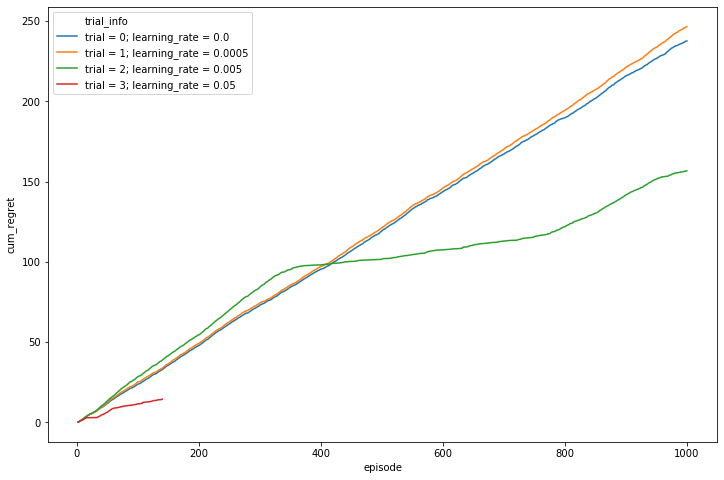

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

g = sns.lineplot(
    data=agg_performance_results,
    x="episode",
    y="cum_regret",
    hue="trial_info",
    ax=ax,
)

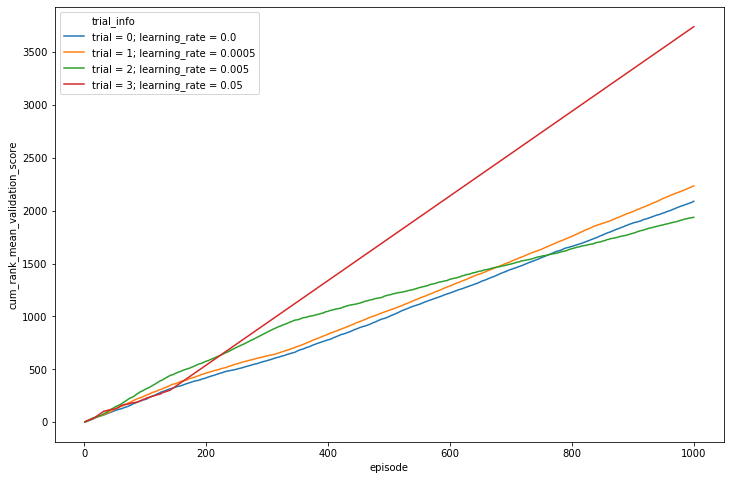

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

g = sns.lineplot(
    data=agg_performance_results,
    x="episode",
    y="cum_rank_mean_validation_score",
    hue="trial_info",
    ax=ax,
)

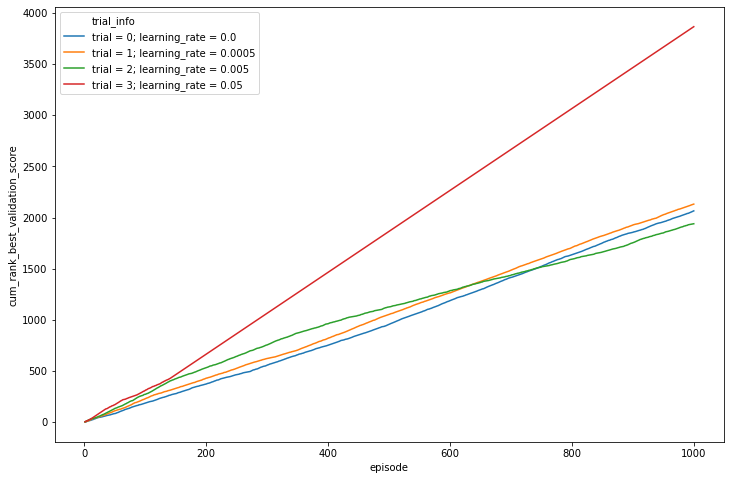

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

g = sns.lineplot(
    data=agg_performance_results,
    x="episode",
    y="cum_rank_best_validation_score",
    hue="trial_info",
    ax=ax,
)

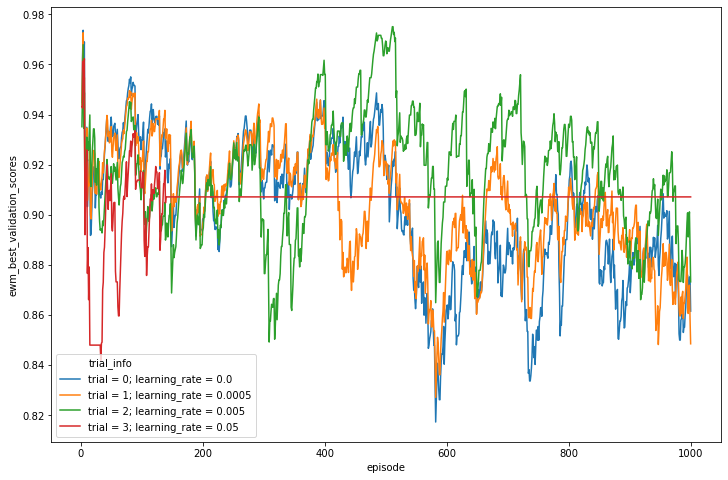

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

g = sns.lineplot(
    data=agg_performance_results,
    x="episode",
    y="ewm_best_validation_scores",
    hue="trial_info",
    ax=ax,
)

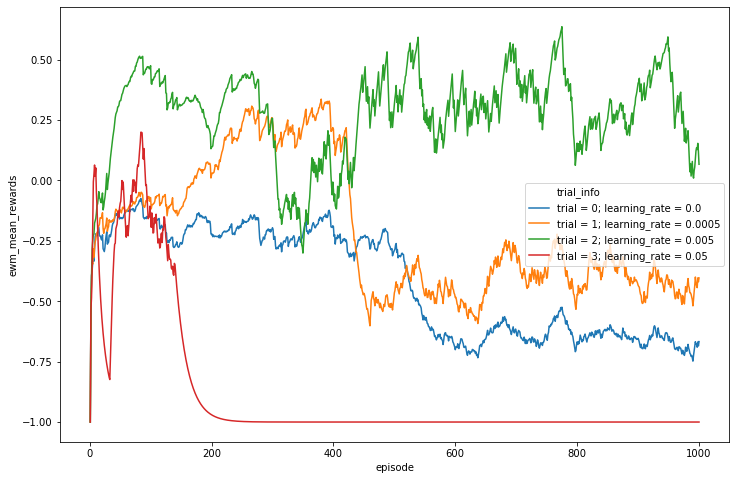

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

g = sns.lineplot(
    data=agg_performance_results,
    x="episode",
    y="ewm_mean_rewards",
    hue="trial_info",
    ax=ax,
)

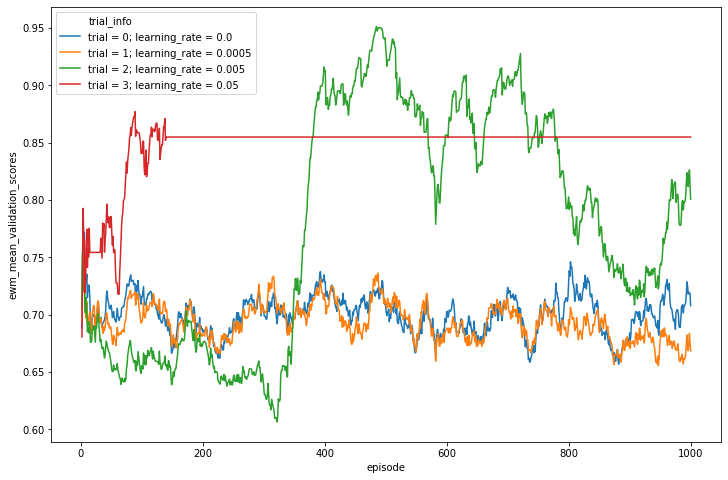

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

g = sns.lineplot(
    data=agg_performance_results,
    x="episode",
    y="ewm_mean_validation_scores",
    hue="trial_info",
    ax=ax,
)

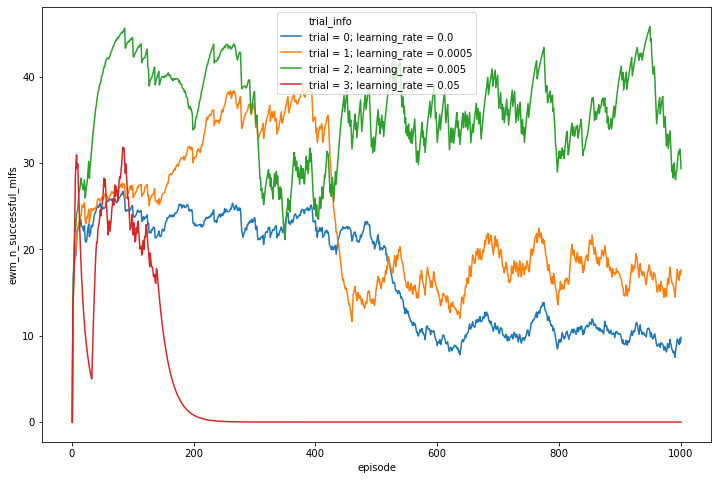

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

g = sns.lineplot(
    data=agg_performance_results,
    x="episode",
    y="ewm_n_successful_mlfs",
    hue="trial_info",
    ax=ax,
)

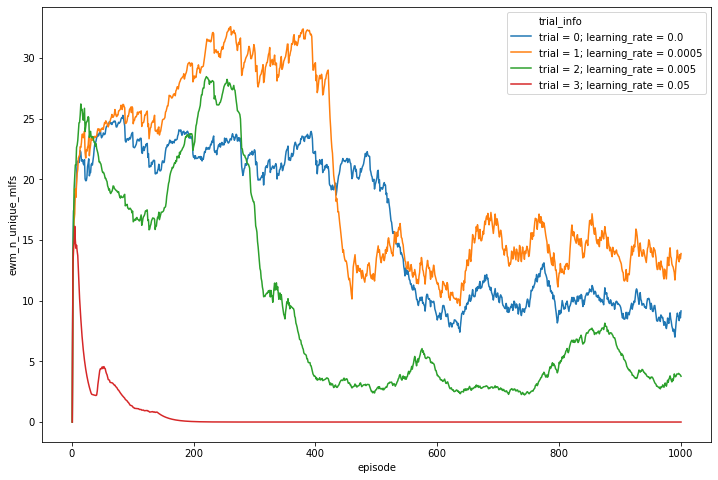

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

g = sns.lineplot(
    data=agg_performance_results,
    x="episode",
    y="ewm_n_unique_mlfs",
    hue="trial_info",
    ax=ax,
)

#### Plot Performance per Dataset

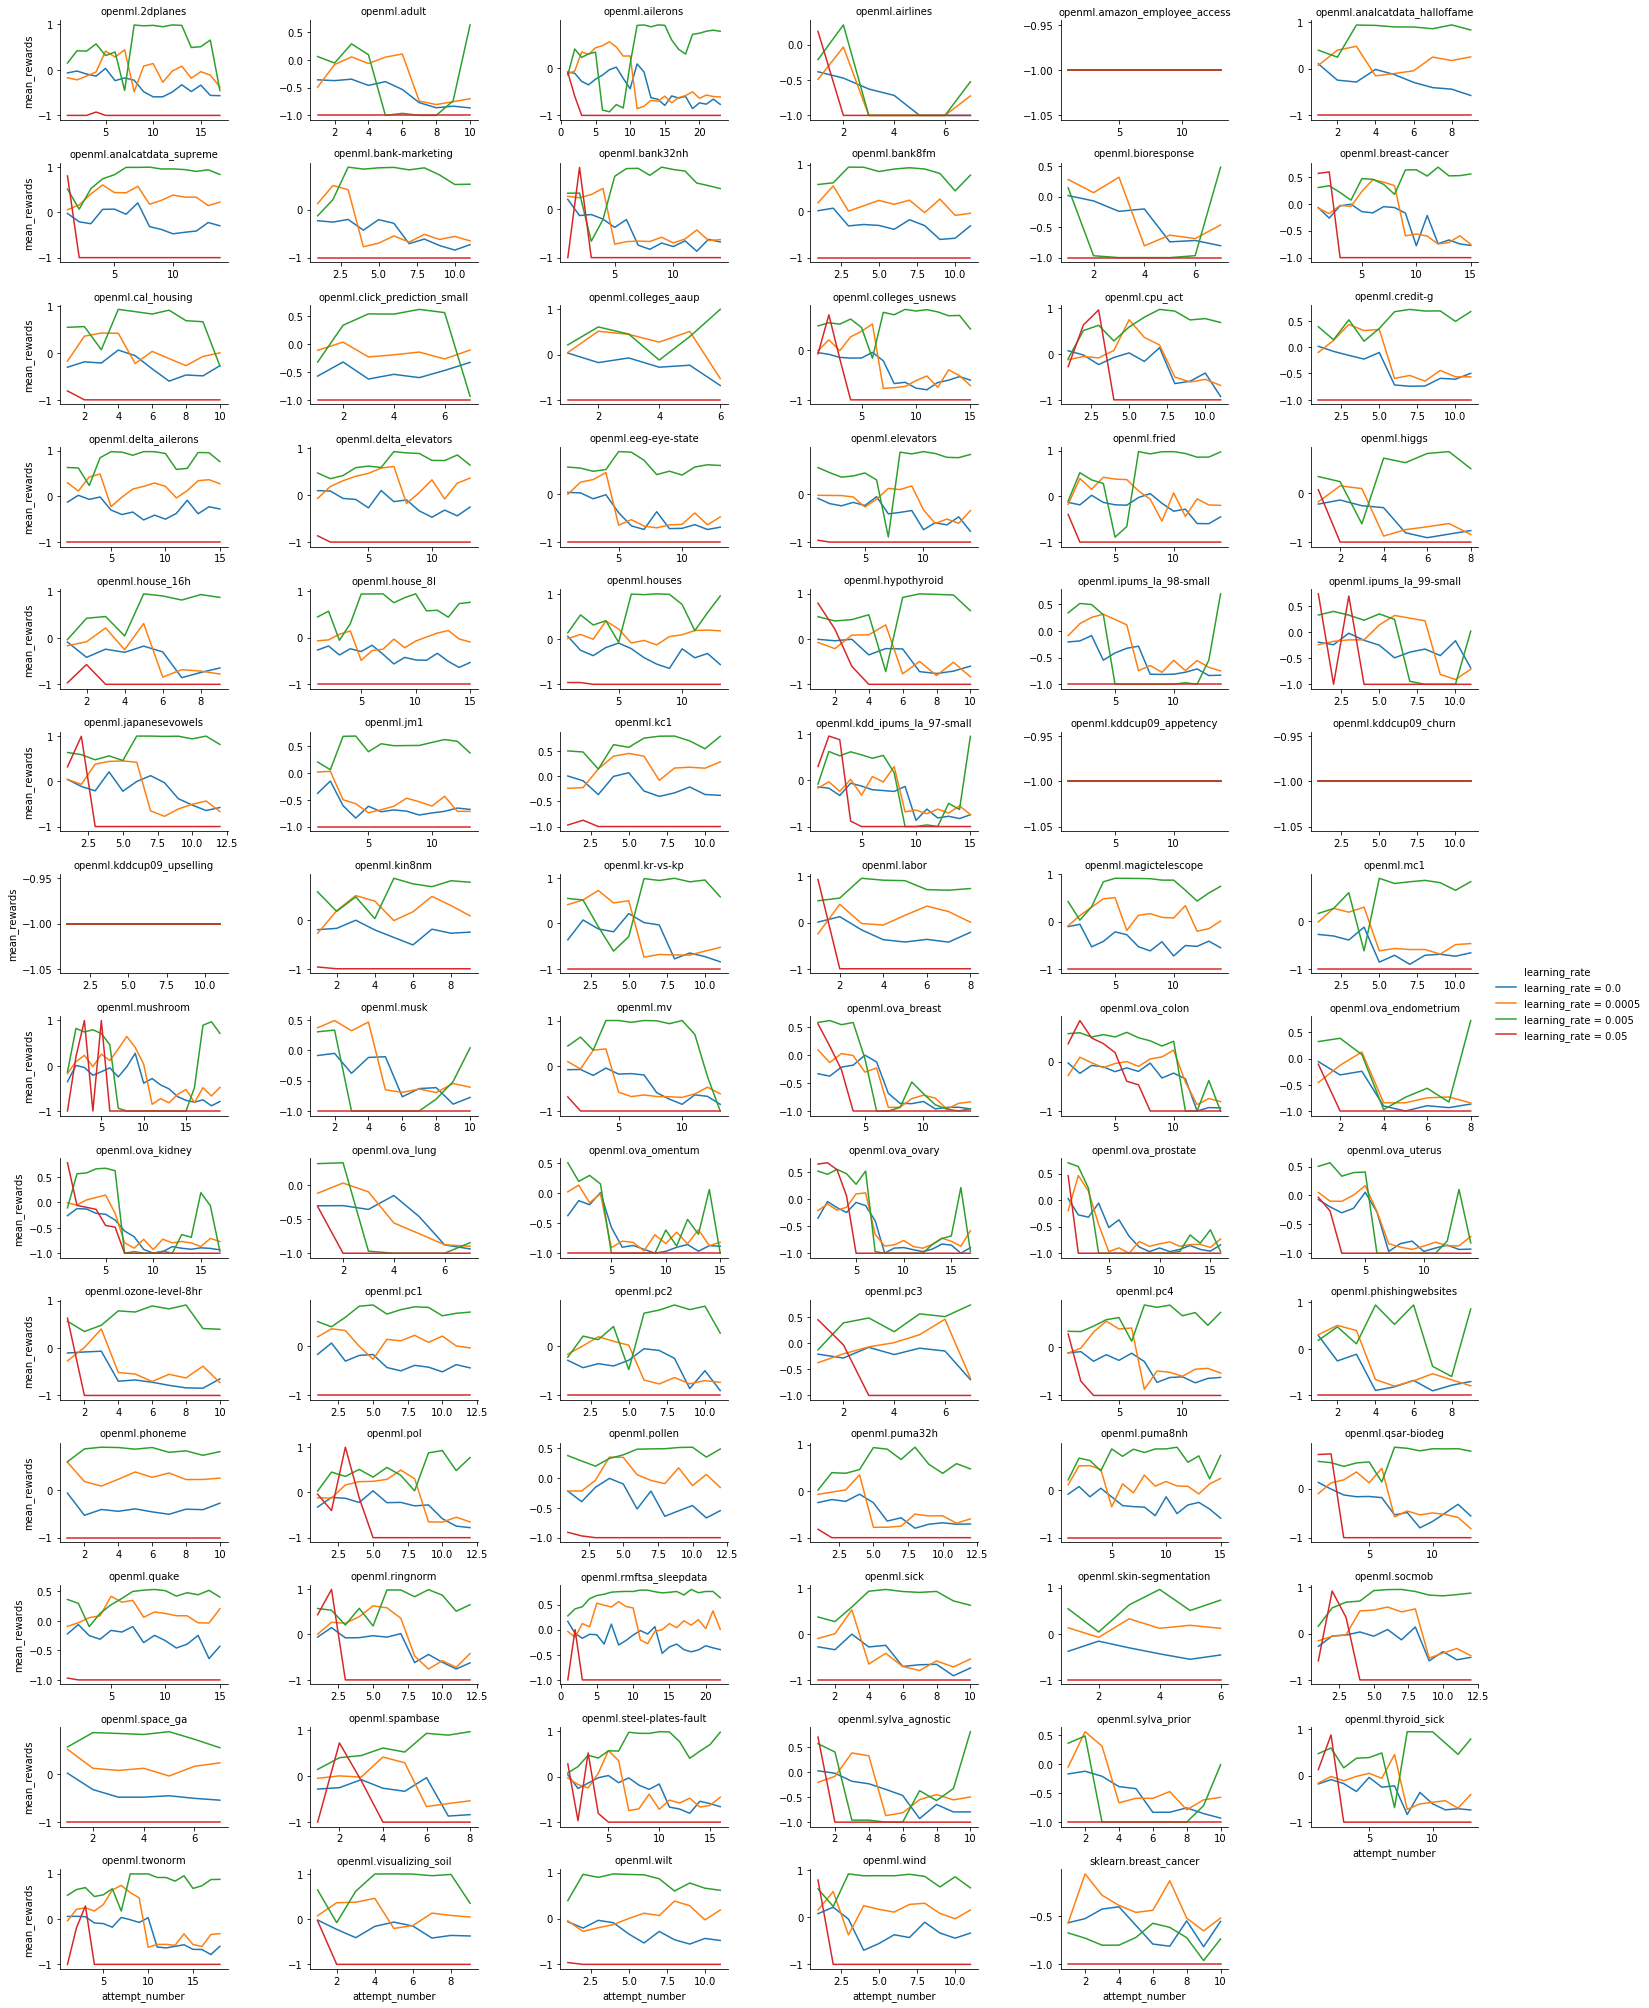

In [31]:
g = sns.relplot(
    x="attempt_number",
    y="mean_rewards",
    kind="line",
    data=(
        training_results
        .groupby(["data_env_names", "trial_num"])
        .apply(lambda df: df.assign(attempt_number=range(1, df.shape[0] + 1)))
        .reset_index(drop=True)
        .assign(learning_rate=lambda df: "learning_rate = " + df.learning_rate.astype(str))
    ),
    col="data_env_names",
    col_wrap=6,
    hue="learning_rate",
    height=2,
    aspect=1.75,
    facet_kws={
        "sharex": False,
        "sharey": False,
    }
)
g.set_titles("{col_name}")

## Inference

In [86]:
check_betw_zero_one = pa.Check(lambda s: (0.0 <= s) & (s <= 1.0))

INFERENCE_RESULT_SCHEMA = pa.DataFrameSchema(
    columns={
        "data_env": pa.Column(pa.String),
        "n_inference_steps": pa.Column(pa.Int),
        "is_valid": pa.Column(pa.Bool),
        "reward": pa.Column(pa.Float),
        "validation_score": pa.Column(pa.Float),
    },
    coerce=True,
)

@pa.check_output(INFERENCE_RESULT_SCHEMA)
def data_to_longform(inference_results):
    df = (
        inference_results
        [["data_env_partition", "trial_num",
          "data_env", "n_inference_steps", "key", "value"]]
        .pivot_table(
            index=[
                "data_env_partition", "trial_num",
                "data_env", "n_inference_steps",
            ],
            columns="key",
            values="value",
            aggfunc=lambda x: x,
        )
        .reset_index()
    )
    return (
        df
        .loc[
            lambda df: (
                # all scores should be strings
                df.validation_score.map(lambda x: isinstance(x, str)) &
                df.mlf.map(lambda x: isinstance(x, str)) &
                df.reward.map(lambda x: isinstance(x, str)) &
                df.is_valid.map(lambda x: isinstance(x, str))
            )
        ]
        .rename_axis(None, axis=1)
        .reset_index(drop=True)
    )

In [270]:
with tarfile.open(OUTPUT_PATH) as tar:
    inference_results = (
        pd.concat([
            (
                pd.read_csv(tar.extractfile(member))
                .assign(
                    data_env_partition=env,
                    trial_num=int(
                        re.search(
                            r".+_trial_(?P<trial_num>[0-9])\.csv",
                            str(member.name)
                        ).group("trial_num")
                    )
                )
            )
            for env in ["training", "test"]
            for member in (
                m for m in tar.getmembers()
                if m.name.startswith(f"./{env}_env_inference_results_trial_")
            )
        ])
        .pipe(data_to_longform)
        .sort_values(["data_env_partition", "trial_num", "n_inference_steps"])
        # add exponentially-weighted metrics
        .groupby(["data_env_partition", "data_env"])
        .apply(
            lambda group: group.assign(
                ewm_validation_score=group.ewm(span=30).validation_score.mean()
            )
        )
        .reset_index(drop=True)
        .assign(
            ewm_validation_score_centered=lambda df: (
                df.ewm_validation_score - (
                    df.groupby(["data_env_partition", "data_env"])
                    .ewm_validation_score.transform("first")
                )
            ),
            learning_rate=lambda df: df.trial_num.map(lambda x: trial_num_map[x]["learning_rate"]),
            target_type=lambda df: df.target_type.str.replace("^TargetType.", "")
        )
    )

inference_results.head()

,data_env_partition,trial_num,data_env,n_inference_steps,is_valid,mlf,mlf_full,reward,scorer,target_type,validation_score,ewm_validation_score,ewm_validation_score_centered,learning_rate
0,test,0,kaggle.house_prices_advanced_regression_techni...,8,True,SimpleImputer > OneHotEncoder > Normalizer > R...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.088448,r2,REGRESSION,0.088448,0.088448,0.000000,0.0
1,test,0,kaggle.house_prices_advanced_regression_techni...,9,True,SimpleImputer > OneHotEncoder > MinMaxScaler >...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.000000,r2,REGRESSION,-0.001432,0.042010,-0.046438,0.0
2,test,0,kaggle.house_prices_advanced_regression_techni...,12,True,SimpleImputer > OneHotEncoder > Normalizer > R...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.000000,r2,REGRESSION,-0.865454,-0.280860,-0.369308,0.0
3,test,0,kaggle.house_prices_advanced_regression_techni...,13,True,SimpleImputer > OneHotEncoder > Normalizer > V...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.781761,r2,REGRESSION,0.781761,0.011931,-0.076517,0.0
4,test,0,kaggle.house_prices_advanced_regression_techni...,14,True,SimpleImputer > OneHotEncoder > StandardScaler...,{'SimpleImputer': ColumnTransformer(n_jobs=Non...,0.593626,r2,REGRESSION,0.593626,0.144280,0.055833,0.0


In [292]:
inference_results.trial_num.unique()

array([0, 1, 2])

## Plot Best Validation Scores on Training and Test Dataset Splits

In [271]:
total_n_shots = inference_results.n_inference_steps.max()
display(Markdown(f"Number of shots per trial: {total_n_shots}"))

Number of shots per trial: 49

In [272]:
# get mean/max reward/validation score per dataset
inference_aggregated_data_env_scores = (
    inference_results
    .groupby(["data_env_partition", "data_env", "trial_num", "target_type", "learning_rate"])
    .agg({"validation_score": ["max", "mean"], "reward": ["max", "mean"]})
    .set_axis(
        ["max_validation_score", "mean_validation_score", "max_reward", "mean_reward"],
        axis="columns", inplace=False)
    .reset_index()
)

# aggregate performance metrics per trial
aggregated_overall_scores = (
    inference_aggregated_data_env_scores
    .groupby(["data_env_partition", "trial_num", "target_type", "learning_rate"])
    [["max_validation_score", "mean_validation_score", "max_reward", "mean_reward"]]
    .mean()
)
aggregated_overall_scores

max_validation_score  \
data_env_partition trial_num target_type learning_rate                         
test               0         BINARY      0.0000                     0.851564   
                             MULTICLASS  0.0000                     0.732279   
                             REGRESSION  0.0000                     0.265217   
                   1         BINARY      0.0005                     0.861691   
                             MULTICLASS  0.0005                     0.780845   
                             REGRESSION  0.0005                     0.352988   
                   2         BINARY      0.0050                     0.852850   
                             MULTICLASS  0.0050                     0.672689   
                             REGRESSION  0.0050                     0.448815   
training           0         BINARY      0.0000                     0.869241   
                   1         BINARY      0.0005                     0.896796   
                   2         BINARY      0.0050                     0.901293   

                                                        mean_validation_score  \
data_env_partition trial_num target_type learning_rate                          
test               0         BINARY      0.0000                      0.676718   
                             MULTICLASS  0.0000                      0.414534   
                             REGRESSION  0.0000                      0.044557   
                   1         BINARY      0.0005                      0.664419   
                             MULTICLASS  0.0005                      0.398945   
                             REGRESSION  0.0005                      0.125372   
                   2         BINARY      0.0050                      0.785283   
                             MULTICLASS  0.0050                      0.543458   
                             REGRESSION  0.0050                     -0.088284   
training           0         BINARY      0.0000                      0.698749   
                   1         BINARY      0.0005                      0.686012   
                   2         BINARY      0.0050                      0.825476   

                                                        max_reward  \
data_env_partition trial_num target_type learning_rate               
test               0         BINARY      0.0000           0.851564   
                             MULTICLASS  0.0000           0.732279   
                             REGRESSION  0.0000           0.265217   
                   1         BINARY      0.0005           0.861691   
                             MULTICLASS  0.0005           0.780845   
                             REGRESSION  0.0005           0.352988   
                   2         BINARY      0.0050           0.852850   
                             MULTICLASS  0.0050           0.672689   
                             REGRESSION  0.0050           0.448815   
training           0         BINARY      0.0000           0.869241   
                   1         BINARY      0.0005           0.896796   
                   2         BINARY      0.0050           0.901293   

                                                        mean_reward  
data_env_partition trial_num target_type learning_rate               
test               0         BINARY      0.0000            0.676718  
                             MULTICLASS  0.0000            0.414534  
                             REGRESSION  0.0000            0.102346  
                   1         BINARY      0.0005            0.664419  
                             MULTICLASS  0.0005            0.398945  
                             REGRESSION  0.0005            0.138523  
                   2         BINARY      0.0050            0.785283  
                             MULTICLASS  0.0050            0.543458  
                             REGRESSION  0.0050            0.243171  
training           0         BINARY      0.0000  

### N-shot Learning Metrics

Evaluate the performance of each learning rate on the training dataset and
test dataset splits to assess generalization performance of the metalearning
system.

In [295]:
def compute_n_shot_performance_metrics(inference_results, n_shots_iter):
    return pd.concat([
        inference_results
        .query("n_inference_steps <= @n_shots")
        .groupby(["data_env_partition", "data_env", "trial_num", "target_type", "learning_rate"])
        .agg({"validation_score": ["max", "mean"], "reward": ["max", "mean"]})
        .set_axis(
            ["max_validation_score", "mean_validation_score", "max_reward", "mean_reward"],
            axis="columns", inplace=False)
        .reset_index()
        .assign(n_shots=n_shots)
        for n_shots in n_shots_iter
    ], ignore_index=True)


def n_shots_to_long(n_shot_performance_metrics):
    return n_shot_performance_metrics.melt(
        id_vars=["n_shots", "data_env_partition", "data_env", "trial_num", "target_type", "learning_rate"],
        value_vars=["max_validation_score", "mean_validation_score", "max_reward", "mean_reward"],
        value_name="score",
        var_name="score_type"
    )

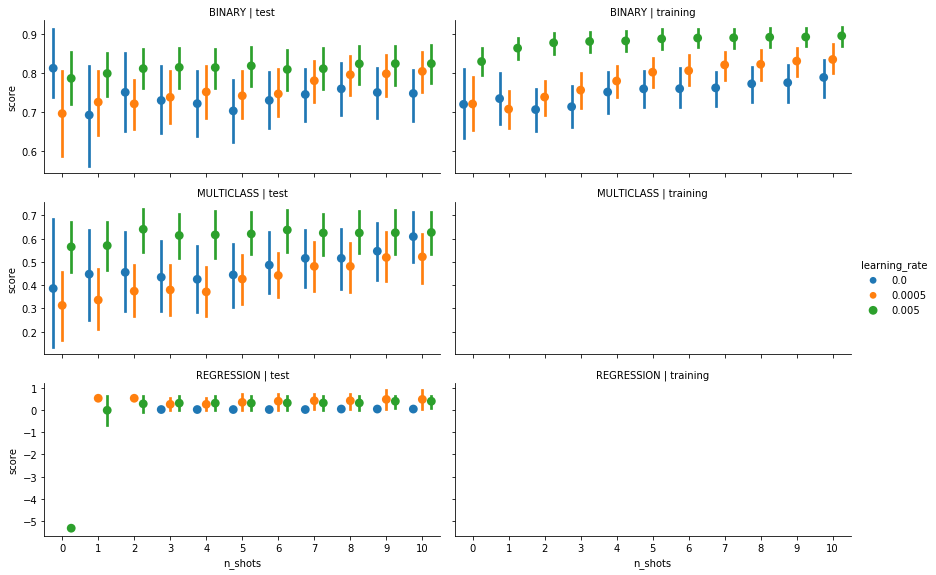

In [306]:
g = sns.catplot(
    x="n_shots",
    y="score",
    hue="learning_rate",
    col="data_env_partition",
    row="target_type",
    row_order=["BINARY", "MULTICLASS", "REGRESSION"],
    kind="point",
    join=False,
    dodge=0.5,
    sharey="row",
    data=(
        compute_n_shot_performance_metrics(inference_results, range(11))
        .pipe(n_shots_to_long)
        .query("score_type == 'max_validation_score'")
    ),
    height=2.7,
    aspect=2.25,
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

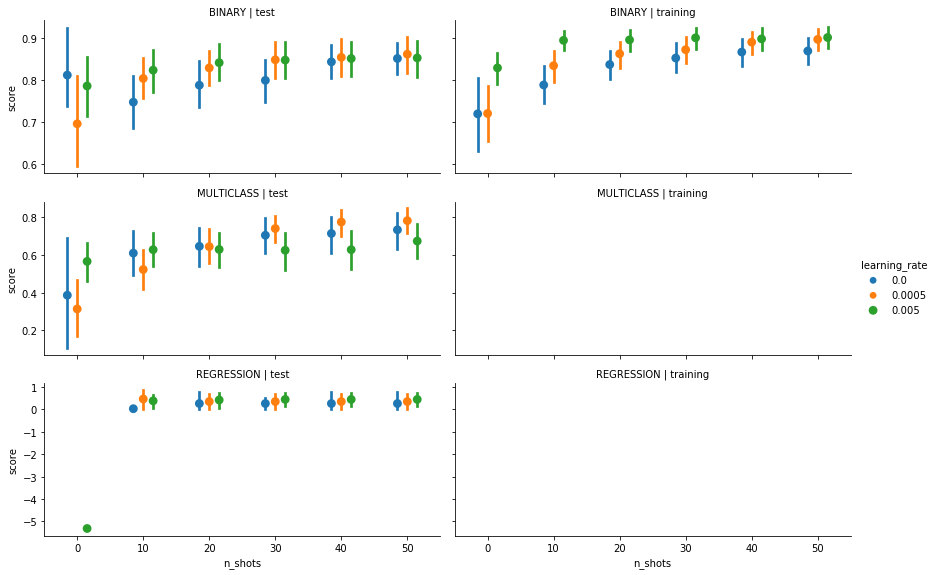

In [302]:
g = sns.catplot(
    x="n_shots",
    y="score",
    hue="learning_rate",
    col="data_env_partition",
    row="target_type",
    row_order=["BINARY", "MULTICLASS", "REGRESSION"],
    kind="point",
    join=False,
    dodge=0.3,
    sharey="row",
    data=(
        compute_n_shot_performance_metrics(inference_results, list(range(0, 51, 10)))
        .pipe(n_shots_to_long)
        .query("score_type == 'max_validation_score'")
    ),
    height=2.7,
    aspect=2.25,
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

## Plot Validation Scores

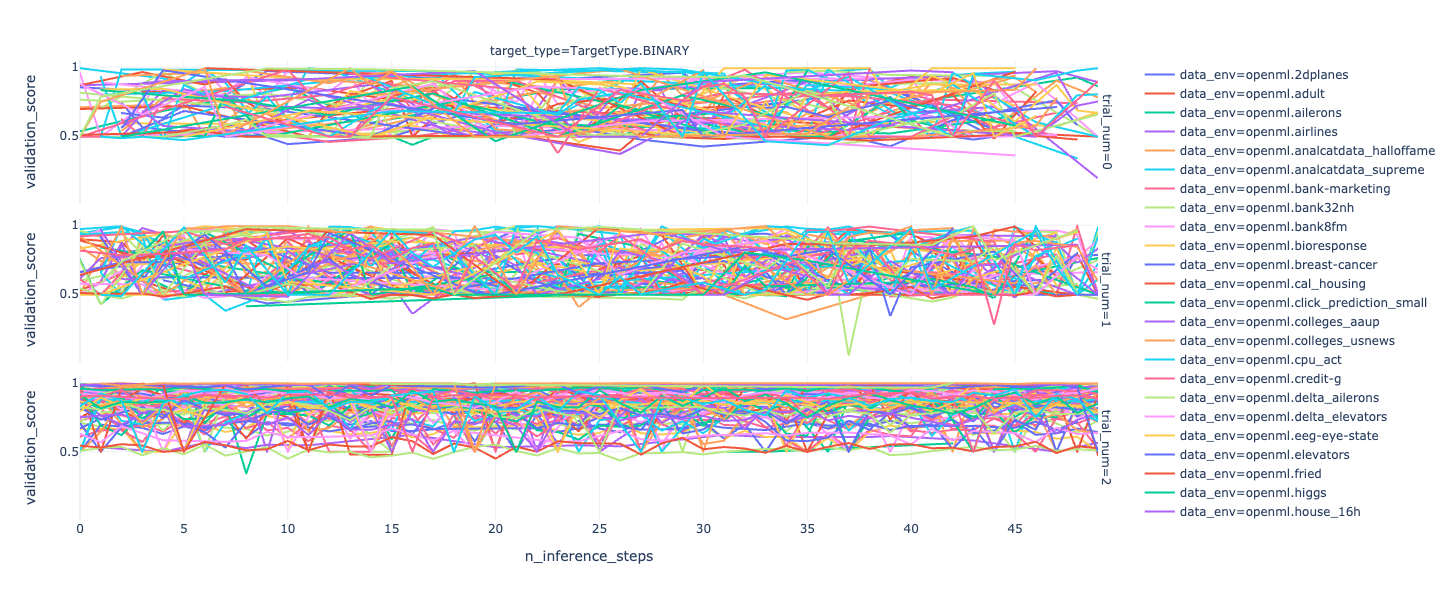

In [88]:
px.line(
    inference_results.query("data_env_partition == 'training'"),
    x="n_inference_steps",
    y="validation_score",
    template="plotly_white",
    color="data_env",
    facet_row="trial_num",
    facet_col="target_type",
)

### Plot of Test Data Environment Validation Scores

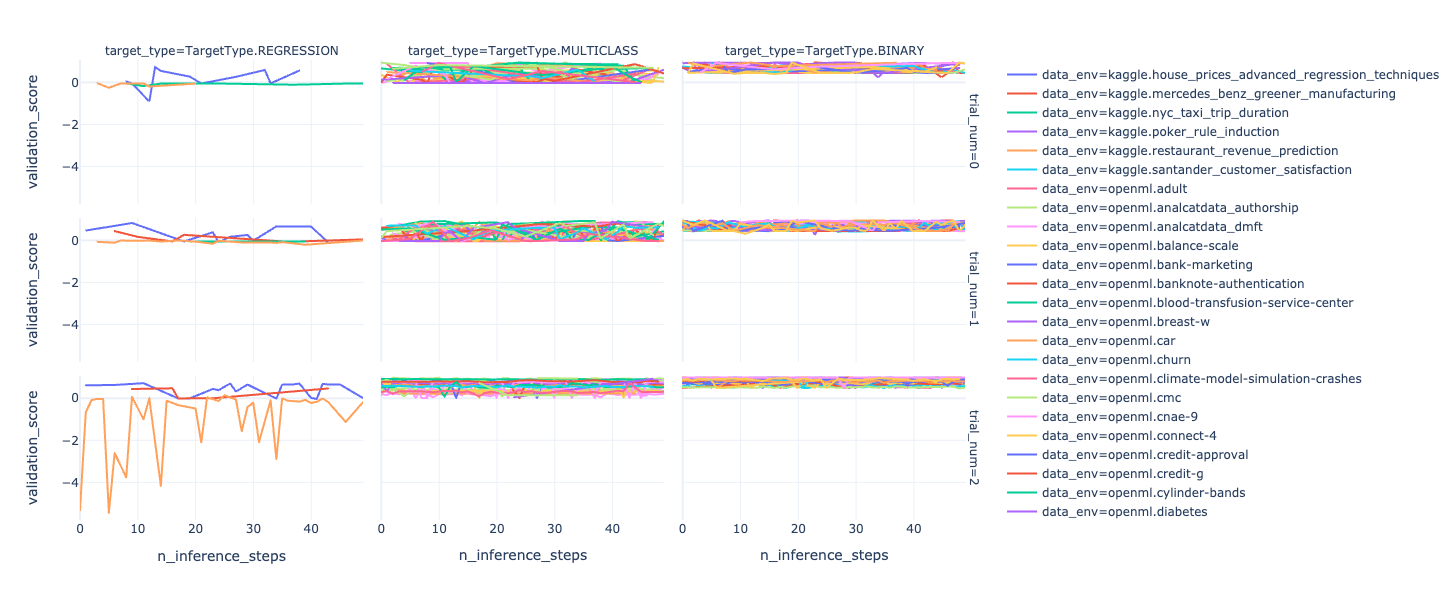

In [75]:
px.line(
    data_frame=(
        inference_results
        .query("data_env_partition == 'test'")
    ),
    x="n_inference_steps",
    y="validation_score",
    template="plotly_white",
    color="data_env",
    facet_row="trial_num",
    facet_col="target_type",
)

In [73]:
with pd.option_context("display.max_rows", 200):
    display(
        inference_results
        .groupby(["data_env_partition", "data_env"])
        .apply(lambda df: df.loc[df.validation_score.idxmax()])
        .reset_index(drop=True)
        .groupby("data_env_partition")
        .apply(lambda df: df.sort_values("validation_score"))
        .head()
    )

data_env_partition  trial_num  \
data_env_partition                                    
test               2                test          0   
                   4                test          2   
                   8                test          2   
                   3                test          1   
                   28               test          0   

                                                   data_env  \
data_env_partition                                            
test               2          kaggle.nyc_taxi_trip_duration   
                   4   kaggle.restaurant_revenue_prediction   
                   8                openml.analcatdata_dmft   
                   3            kaggle.poker_rule_induction   
                   28    openml.first-order-theorem-proving   

                       n_inference_steps  is_valid  \
data_env_partition                                   
test               2                   8      True   
                   4                  25      True   
                   8                   2      True   
                   3                  22      True   
                   28                 48      True   

                                                                     mlf  \
data_env_partition                                                         
test               2   SimpleImputer > OneHotEncoder > Normalizer > R...   
                   4   SimpleImputer > OneHotEncoder > RobustScaler >...   
                   8   SimpleImputer > OneHotEncoder > RobustScaler >...   
                   3   SimpleImputer > OneHotEncoder > MinMaxScaler >...   
                   28  SimpleImputer > OneHotEncoder > RobustScaler >...   

                                                                mlf_full  \
data_env_partition                                                         
test               2   {'SimpleImputer': ColumnTransformer(n_jobs=Non...   
                   4   {'SimpleImputer': ColumnTransformer(n_jobs=Non...   
                   8   {'SimpleImputer': ColumnTransformer(n_jobs=Non...   
                   3   {'SimpleImputer': ColumnTransformer(n_jobs=Non...   
                   28  {'SimpleImputer': ColumnTransformer(n_jobs=Non...   

                         reward    scorer            target_type  \
data_env_partition                                                 
test               2   0.001695        r2  TargetType.REGRESSION   
                   4   0.142878        r2  TargetType.REGRESSION   
                   8   0.262615  f1_macro  TargetType.MULTICLASS   
                   3   0.417665  f1_macro  TargetType.MULTICLASS   
                   28  0.482172  f1_macro  TargetType.MULTICLASS   

                       validation_score  ewm_validation_score  \
data_env_partition                                              
test               2           0.001695              0.001695   
                   4           0.142878             -0.875072   
                   8           0.262615              0.123588   
                   3           0.417665              0.182640   
                   28          0.482172              0.204298   

                       ewm_validation_score_centered  
data_env_partition                                    
test               2                        0.000000  
                   4                       -0.887266  
                   8                        0.010747  
                   3                        0.075858  
                   28                      -0.053139